# Week 8, Day 6: Strategy Backtesting with ML Signals

## Learning Objectives
- Build a complete ML-driven trading system
- Implement realistic backtesting with transaction costs
- Calculate risk-adjusted performance metrics
- Analyze strategy behavior across market regimes

## Key Concepts

### Sharpe Ratio
$$\text{Sharpe} = \frac{E[R_p - R_f]}{\sigma_p} \times \sqrt{252}$$

### Maximum Drawdown
$$\text{MDD} = \max_t \left( \frac{\text{Peak}_t - \text{Value}_t}{\text{Peak}_t} \right)$$

### Transaction Cost Impact
$$R_{\text{net}} = R_{\text{gross}} - c \times |\Delta_{\text{position}}|$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Load data
data_path = '../datasets/raw_data/combined_adjusted_close.csv'
prices = pd.read_csv(data_path, index_col='Date', parse_dates=True)
print(f"Data loaded: {prices.shape[0]} rows, {prices.shape[1]} columns")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")

Data loaded: 1836 rows, 63 columns
Date range: 2019-01-01 00:00:00 to 2026-01-19 00:00:00


In [2]:
def create_features(price_series):
    """Create ML features with proper lagging to avoid look-ahead bias."""
    df = pd.DataFrame(index=price_series.index)
    
    # Returns at multiple horizons (lagged by 1 day)
    for period in [1, 5, 10, 20]:
        df[f'ret_{period}d'] = price_series.pct_change(period).shift(1)
    
    # Moving average crossovers
    sma_5 = price_series.rolling(5).mean()
    sma_20 = price_series.rolling(20).mean()
    df['sma_cross'] = ((sma_5 / sma_20) - 1).shift(1)
    df['price_vs_sma20'] = ((price_series / sma_20) - 1).shift(1)
    
    # RSI (14-day)
    delta = price_series.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = (100 - 100 / (1 + gain / loss)).shift(1)
    
    # Volatility
    df['volatility'] = price_series.pct_change().rolling(20).std().shift(1)
    
    # Target: next day return direction
    df['target_return'] = price_series.pct_change().shift(-1)
    df['target_direction'] = (df['target_return'] > 0).astype(int)
    
    return df.dropna()

# Create features
spy_data = create_features(prices['SPY'])
feature_cols = [c for c in spy_data.columns if 'target' not in c]
print(f"Features: {feature_cols}")
print(f"Total samples: {len(spy_data)}")

Features: ['ret_1d', 'ret_5d', 'ret_10d', 'ret_20d', 'sma_cross', 'price_vs_sma20', 'rsi', 'volatility']
Total samples: 737


## 1. Backtester Class

A complete backtesting framework that handles:
- Position management
- Transaction costs
- Performance metrics
- Risk analytics

In [3]:
class MLBacktester:
    """
    Complete backtesting framework for ML-based trading strategies.
    
    Parameters:
    -----------
    transaction_cost : float
        Cost per trade as fraction (e.g., 0.001 = 10 bps)
    slippage : float
        Slippage per trade as fraction
    """
    
    def __init__(self, transaction_cost=0.001, slippage=0.0005):
        self.transaction_cost = transaction_cost
        self.slippage = slippage
        self.results = None
    
    def backtest(self, returns, signals):
        """
        Run backtest given returns and signals.
        
        Parameters:
        -----------
        returns : pd.Series
            Actual returns (aligned with signals)
        signals : np.array
            Trading signals: 1 (long), -1 (short), 0 (flat)
        """
        # Ensure arrays
        returns = np.array(returns)
        signals = np.array(signals)
        
        # Calculate position changes for transaction costs
        position_changes = np.abs(np.diff(np.concatenate([[0], signals])))
        
        # Gross strategy returns
        gross_returns = signals * returns
        
        # Net returns after costs
        total_cost = (self.transaction_cost + self.slippage) * position_changes
        net_returns = gross_returns - total_cost
        
        # Store results
        self.results = {
            'gross_returns': gross_returns,
            'net_returns': net_returns,
            'signals': signals,
            'position_changes': position_changes,
            'total_costs': total_cost
        }
        
        return self
    
    def get_metrics(self):
        """Calculate comprehensive performance metrics."""
        if self.results is None:
            raise ValueError("Run backtest first!")
        
        net_rets = self.results['net_returns']
        gross_rets = self.results['gross_returns']
        signals = self.results['signals']
        
        # Cumulative returns
        cum_net = (1 + net_rets).cumprod()
        cum_gross = (1 + gross_rets).cumprod()
        
        # Total return
        total_return = cum_net[-1] - 1
        
        # Annualized return
        n_years = len(net_rets) / 252
        ann_return = (1 + total_return) ** (1/n_years) - 1 if n_years > 0 else 0
        
        # Volatility
        ann_vol = net_rets.std() * np.sqrt(252)
        
        # Sharpe ratio
        sharpe = ann_return / ann_vol if ann_vol > 0 else 0
        
        # Maximum drawdown
        peak = np.maximum.accumulate(cum_net)
        drawdown = (peak - cum_net) / peak
        max_dd = drawdown.max()
        
        # Win rate
        trading_days = signals != 0
        if trading_days.sum() > 0:
            win_rate = (net_rets[trading_days] > 0).sum() / trading_days.sum()
        else:
            win_rate = 0
        
        # Number of trades
        n_trades = self.results['position_changes'].sum() / 2  # Entry + exit = 1 trade
        
        # Total costs
        total_costs = self.results['total_costs'].sum()
        
        # Calmar ratio (return / max drawdown)
        calmar = ann_return / max_dd if max_dd > 0 else 0
        
        return {
            'Total Return': total_return,
            'Annualized Return': ann_return,
            'Annualized Volatility': ann_vol,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_dd,
            'Calmar Ratio': calmar,
            'Win Rate': win_rate,
            'Num Trades': n_trades,
            'Total Costs': total_costs,
            'Cumulative Returns': cum_net
        }
    
    def plot_results(self, benchmark_returns=None, title='Strategy Performance'):
        """Plot backtest results."""
        metrics = self.get_metrics()
        cum_rets = metrics['Cumulative Returns']
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))
        
        # Cumulative returns
        axes[0].plot(cum_rets, label='Strategy (Net)', linewidth=2)
        if benchmark_returns is not None:
            bm_cum = (1 + benchmark_returns).cumprod()
            axes[0].plot(bm_cum.values, label='Benchmark', alpha=0.7)
        axes[0].set_title(title)
        axes[0].set_ylabel('Cumulative Return')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Drawdown
        peak = np.maximum.accumulate(cum_rets)
        drawdown = (peak - cum_rets) / peak
        axes[1].fill_between(range(len(drawdown)), drawdown, alpha=0.5, color='red')
        axes[1].set_title(f'Drawdown (Max: {metrics["Max Drawdown"]:.2%})')
        axes[1].set_ylabel('Drawdown')
        axes[1].grid(True, alpha=0.3)
        
        # Signals
        axes[2].plot(self.results['signals'], alpha=0.7)
        axes[2].set_title('Trading Signals')
        axes[2].set_ylabel('Position')
        axes[2].set_xlabel('Time')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("MLBacktester class defined successfully.")

MLBacktester class defined successfully.


## 2. Walk-Forward ML Strategy

In [4]:
def walk_forward_ml_strategy(data, feature_cols, train_size=252, test_size=63, 
                              model_class=GradientBoostingClassifier, 
                              model_params=None, threshold=0.5):
    """
    Generate ML signals using walk-forward methodology.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame with features and target columns
    feature_cols : list
        List of feature column names
    train_size : int
        Number of days for training window
    test_size : int
        Number of days for test/trading window
    model_class : class
        sklearn model class
    model_params : dict
        Model hyperparameters
    threshold : float
        Probability threshold for signals
    """
    if model_params is None:
        model_params = {'n_estimators': 100, 'max_depth': 3, 'random_state': 42}
    
    n = len(data)
    all_signals = []
    all_probas = []
    all_dates = []
    all_returns = []
    
    start = train_size
    
    while start + test_size <= n:
        # Training data
        train_data = data.iloc[start-train_size:start]
        X_train = train_data[feature_cols]
        y_train = train_data['target_direction']
        
        # Test data
        test_data = data.iloc[start:start+test_size]
        X_test = test_data[feature_cols]
        
        # Train model
        model = model_class(**model_params)
        model.fit(X_train, y_train)
        
        # Get predictions
        probas = model.predict_proba(X_test)[:, 1]
        
        # Generate signals
        signals = np.zeros(len(probas))
        signals[probas > threshold + 0.05] = 1   # Long
        signals[probas < threshold - 0.05] = -1  # Short
        
        # Store results
        all_signals.extend(signals)
        all_probas.extend(probas)
        all_dates.extend(test_data.index.tolist())
        all_returns.extend(test_data['target_return'].values)
        
        start += test_size
    
    return {
        'signals': np.array(all_signals),
        'probabilities': np.array(all_probas),
        'dates': all_dates,
        'returns': np.array(all_returns)
    }

# Run walk-forward strategy
wf_results = walk_forward_ml_strategy(
    spy_data, 
    feature_cols,
    train_size=252,  # 1 year training
    test_size=63,    # 3 months testing
    model_params={'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'random_state': 42}
)

print(f"Walk-forward predictions: {len(wf_results['signals'])}")
print(f"Long signals: {(wf_results['signals'] == 1).sum()}")
print(f"Short signals: {(wf_results['signals'] == -1).sum()}")
print(f"No trade: {(wf_results['signals'] == 0).sum()}")

Walk-forward predictions: 441
Long signals: 204
Short signals: 142
No trade: 95


## 3. Run Backtest with Different Cost Scenarios

In [5]:
# Backtest with different transaction costs
cost_scenarios = [
    {'name': 'No Costs', 'cost': 0.0, 'slip': 0.0},
    {'name': 'Low Costs (5 bps)', 'cost': 0.0005, 'slip': 0.0002},
    {'name': 'Medium Costs (10 bps)', 'cost': 0.001, 'slip': 0.0005},
    {'name': 'High Costs (20 bps)', 'cost': 0.002, 'slip': 0.001},
]

cost_results = []

for scenario in cost_scenarios:
    bt = MLBacktester(
        transaction_cost=scenario['cost'],
        slippage=scenario['slip']
    )
    bt.backtest(wf_results['returns'], wf_results['signals'])
    metrics = bt.get_metrics()
    
    cost_results.append({
        'Scenario': scenario['name'],
        'Total Return': f"{metrics['Total Return']:.2%}",
        'Sharpe': f"{metrics['Sharpe Ratio']:.2f}",
        'Max DD': f"{metrics['Max Drawdown']:.2%}",
        'Win Rate': f"{metrics['Win Rate']:.2%}",
        'Total Costs': f"{metrics['Total Costs']:.4f}"
    })

print("Impact of Transaction Costs")
print("="*80)
print(pd.DataFrame(cost_results).to_string(index=False))

Impact of Transaction Costs
             Scenario Total Return Sharpe Max DD Win Rate Total Costs
             No Costs        3.77%   0.13 28.04%   51.16%      0.0000
    Low Costs (5 bps)      -13.64%  -0.49 31.32%   49.71%      0.1834
Medium Costs (10 bps)      -30.01%  -1.11 35.90%   48.55%      0.3930
  High Costs (20 bps)      -52.84%  -2.05 53.86%   44.22%      0.7860


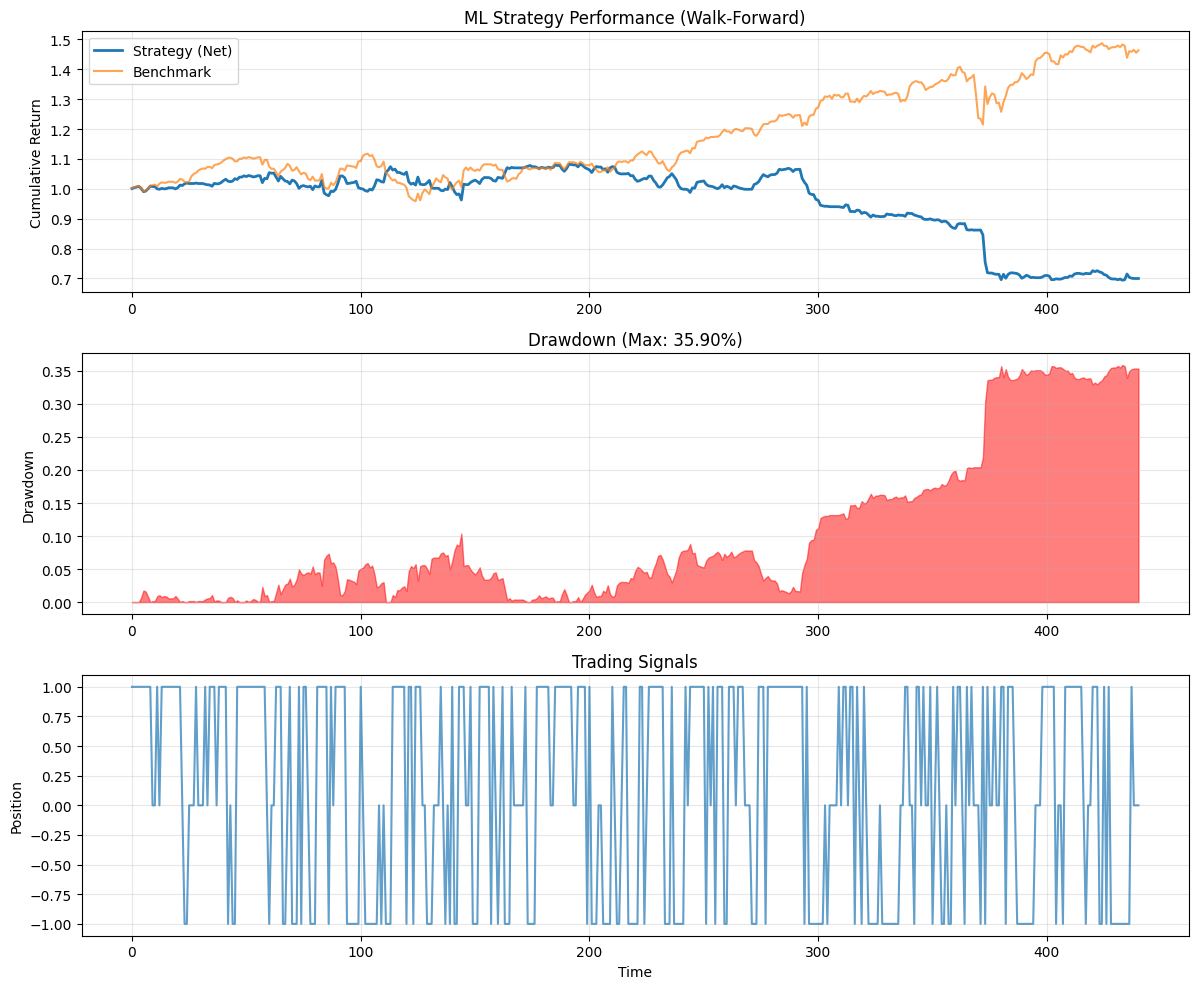

In [6]:
# Detailed backtest with medium costs
bt = MLBacktester(transaction_cost=0.001, slippage=0.0005)
bt.backtest(wf_results['returns'], wf_results['signals'])

# Plot results
bt.plot_results(
    benchmark_returns=pd.Series(wf_results['returns'], index=wf_results['dates']),
    title='ML Strategy Performance (Walk-Forward)'
)

## 4. Strategy Comparison: ML vs Buy-and-Hold

In [7]:
# Compare ML strategy vs buy-and-hold
metrics = bt.get_metrics()

# Buy and hold metrics
bh_returns = wf_results['returns']
bh_cum = (1 + bh_returns).cumprod()
bh_total = bh_cum[-1] - 1
bh_vol = bh_returns.std() * np.sqrt(252)
bh_sharpe = (bh_returns.mean() * 252) / bh_vol if bh_vol > 0 else 0

# Max drawdown for buy-and-hold
bh_peak = np.maximum.accumulate(bh_cum)
bh_dd = ((bh_peak - bh_cum) / bh_peak).max()

comparison = pd.DataFrame({
    'Metric': ['Total Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate'],
    'ML Strategy': [
        f"{metrics['Total Return']:.2%}",
        f"{metrics['Annualized Volatility']:.2%}",
        f"{metrics['Sharpe Ratio']:.2f}",
        f"{metrics['Max Drawdown']:.2%}",
        f"{metrics['Win Rate']:.2%}"
    ],
    'Buy & Hold': [
        f"{bh_total:.2%}",
        f"{bh_vol:.2%}",
        f"{bh_sharpe:.2f}",
        f"{bh_dd:.2%}",
        'N/A'
    ]
})

print("Strategy Comparison")
print("="*60)
print(comparison.to_string(index=False))

Strategy Comparison
        Metric ML Strategy Buy & Hold
  Total Return     -30.01%     46.34%
Annualized Vol      16.60%     18.72%
  Sharpe Ratio       -1.11       1.26
  Max Drawdown      35.90%     14.21%
      Win Rate      48.55%        N/A


## 5. Monthly Performance Analysis

In [8]:
# Create monthly returns DataFrame
results_df = pd.DataFrame({
    'date': wf_results['dates'],
    'strategy_return': bt.results['net_returns'],
    'benchmark_return': wf_results['returns']
})
results_df['date'] = pd.to_datetime(results_df['date'])
results_df.set_index('date', inplace=True)

# Monthly aggregation
monthly = results_df.resample('ME').apply(lambda x: (1 + x).prod() - 1)

print("Monthly Returns Summary")
print("="*60)
print(f"\nStrategy Monthly Stats:")
print(f"  Mean: {monthly['strategy_return'].mean():.2%}")
print(f"  Std: {monthly['strategy_return'].std():.2%}")
print(f"  Best: {monthly['strategy_return'].max():.2%}")
print(f"  Worst: {monthly['strategy_return'].min():.2%}")

print(f"\nBenchmark Monthly Stats:")
print(f"  Mean: {monthly['benchmark_return'].mean():.2%}")
print(f"  Std: {monthly['benchmark_return'].std():.2%}")
print(f"  Best: {monthly['benchmark_return'].max():.2%}")
print(f"  Worst: {monthly['benchmark_return'].min():.2%}")

Monthly Returns Summary

Strategy Monthly Stats:
  Mean: -0.64%
  Std: 3.39%
  Best: 4.71%
  Worst: -17.58%

Benchmark Monthly Stats:
  Mean: 0.78%
  Std: 2.51%
  Best: 7.72%
  Worst: -3.71%


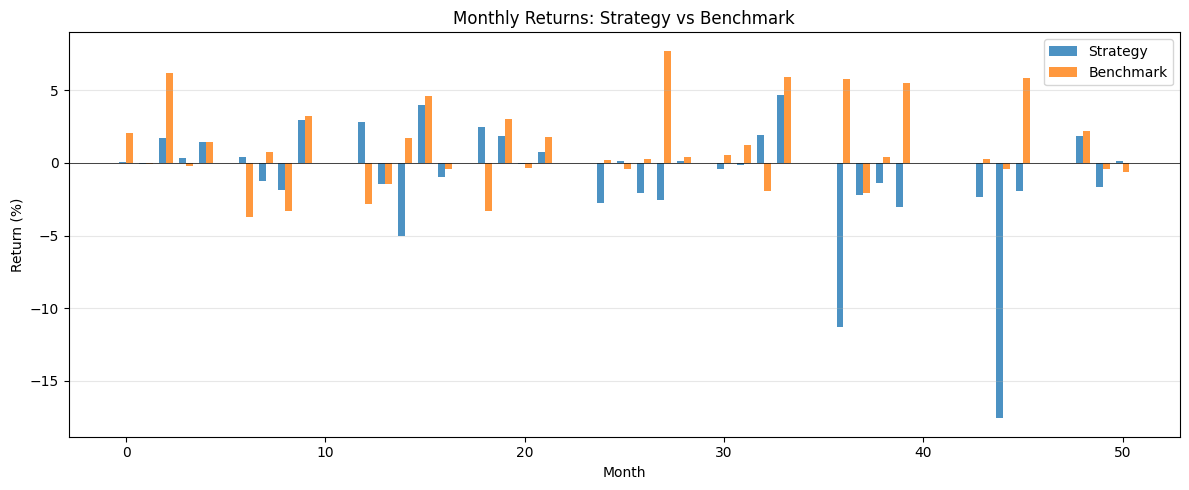

In [9]:
# Plot monthly returns
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(monthly))
width = 0.35

ax.bar(x - width/2, monthly['strategy_return'] * 100, width, label='Strategy', alpha=0.8)
ax.bar(x + width/2, monthly['benchmark_return'] * 100, width, label='Benchmark', alpha=0.8)

ax.set_xlabel('Month')
ax.set_ylabel('Return (%)')
ax.set_title('Monthly Returns: Strategy vs Benchmark')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## 6. Practice Exercises

1. **Position Sizing**: Implement Kelly criterion or volatility-adjusted position sizing.

2. **Risk Limits**: Add daily loss limits and position constraints.

3. **Multi-Asset**: Extend the backtester to trade multiple assets.

4. **Regime Analysis**: Analyze strategy performance in different market regimes.

In [10]:
# Exercise: Analyze performance by volatility regime
results_df['volatility'] = results_df['benchmark_return'].rolling(20).std()
results_df['vol_regime'] = pd.qcut(results_df['volatility'].dropna(), q=3, labels=['Low Vol', 'Med Vol', 'High Vol'])

regime_analysis = results_df.groupby('vol_regime', observed=True).agg({
    'strategy_return': ['mean', 'std', 'count'],
    'benchmark_return': ['mean', 'std']
}).round(4)

print("Performance by Volatility Regime")
print("="*60)
print(regime_analysis)

Performance by Volatility Regime
           strategy_return               benchmark_return        
                      mean     std count             mean     std
vol_regime                                                       
Low Vol             0.0004  0.0058   141           0.0013  0.0064
Med Vol            -0.0019  0.0080   140           0.0007  0.0088
High Vol           -0.0009  0.0156   141           0.0008  0.0178


## Summary

Today we learned:
- Building a complete ML backtesting framework
- Impact of transaction costs on strategy performance
- Key metrics: Sharpe ratio, max drawdown, win rate
- Walk-forward validation for realistic backtesting
- Comparing ML strategies to buy-and-hold benchmarks

### Key Formulas:
- **Sharpe Ratio**: $\frac{\bar{R} - R_f}{\sigma} \times \sqrt{252}$
- **Max Drawdown**: $\max\left(\frac{\text{Peak} - \text{Current}}{\text{Peak}}\right)$
- **Win Rate**: $\frac{\text{Profitable Trades}}{\text{Total Trades}}$